# Introduction

This is a submission to the Petals to the Metal comptetition on Kaggle, where one is asked to develop a model to classify flowers into a list of species.
My approach is based on an ensemble of 2 deep neural network models.
These models are trained in 2 steps.

1. We start by adding an extra layer to a pretrained DenseNet model and training it while the DenseNet weights are frozen.
2. We unfreeze the DenseNet weights and train the whole model.

When making the final predictions, we take the averages of the predicted probabilities of the models in the ensemble and choose the class with the highest probability.

# Importing dependencies and initializing TPU

In [1]:
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import re

print("Tensorflow version " + tf.__version__)

2022-10-18 09:28:52.294790: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-10-18 09:28:52.294910: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow version 2.4.1


In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2022-10-18 09:28:57.346941: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-18 09:28:57.349859: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-10-18 09:28:57.349890: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-18 09:28:57.349931: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (7a71498086bf): /proc/driver/nvidia/version does not exist
2022-10-18 09:28:57.353329: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


# Loading the data

In [3]:
IMAGE_SIZE = [512, 512]
CLASSES = 104
BATCH_SIZE = max(8 * strategy.num_replicas_in_sync, 64)
DATA_AUGMENTATIONS = 0
ENSEMBLE_SIZE = 2

## Data augmentation

The following functions implementing CutMix and MixUp are taken from https://www.kaggle.com/code/yihdarshieh/batch-implementation-of-more-data-augmentations/notebook#Batch-CutMix

In [4]:
def batch_cutmix(images, labels, PROBABILITY=1.0, batch_size=0):
    
    DIM = IMAGE_SIZE[0]
    CLASSES = 104
    
    if batch_size == 0:
        batch_size = BATCH_SIZE
    
    # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
    # This is a tensor containing 0 or 1 -- 0: no cutmix.
    # shape = [batch_size]
    do_cutmix = tf.cast(tf.random.uniform([batch_size], 0, 1) <= PROBABILITY, tf.int32)
    
    # Choose random images in the batch for cutmix
    # shape = [batch_size]
    new_image_indices = tf.cast(tf.random.uniform([batch_size], 0, batch_size), tf.int32)
    
    # Choose random location in the original image to put the new images
    # shape = [batch_size]
    new_x = tf.cast(tf.random.uniform([batch_size], 0, DIM), tf.int32)
    new_y = tf.cast(tf.random.uniform([batch_size], 0, DIM), tf.int32)
    
    # Random width for new images, shape = [batch_size]
    b = tf.random.uniform([batch_size], 0, 1) # this is beta dist with alpha=1.0
    new_width = tf.cast(DIM * tf.math.sqrt(1-b), tf.int32) * do_cutmix
    
    # shape = [batch_size]
    new_y0 = tf.math.maximum(0, new_y - new_width // 2)
    new_y1 = tf.math.minimum(DIM, new_y + new_width // 2)
    new_x0 = tf.math.maximum(0, new_x - new_width // 2)
    new_x1 = tf.math.minimum(DIM, new_x + new_width // 2)
    
    # shape = [batch_size, DIM]
    target = tf.broadcast_to(tf.range(DIM), shape=(batch_size, DIM))
    
    # shape = [batch_size, DIM]
    mask_y = tf.math.logical_and(new_y0[:, tf.newaxis] <= target, target <= new_y1[:, tf.newaxis])
    
    # shape = [batch_size, DIM]
    mask_x = tf.math.logical_and(new_x0[:, tf.newaxis] <= target, target <= new_x1[:, tf.newaxis])    
    
    # shape = [batch_size, DIM, DIM]
    mask = tf.cast(tf.math.logical_and(mask_y[:, :, tf.newaxis], mask_x[:, tf.newaxis, :]), tf.float32)

    # All components are of shape [batch_size, DIM, DIM, 3]
    new_images =  images * tf.broadcast_to(1 - mask[:, :, :, tf.newaxis], [batch_size, DIM, DIM, 3]) + \
                    tf.gather(images, new_image_indices) * tf.broadcast_to(mask[:, :, :, tf.newaxis], [batch_size, DIM, DIM, 3])

    a = tf.cast(new_width ** 2 / DIM ** 2, tf.float32)    
        
    # Make labels
    if len(labels.shape) == 1:
        labels = tf.one_hot(labels, CLASSES)
        
    new_labels =  (1-a)[:, tf.newaxis] * labels + a[:, tf.newaxis] * tf.gather(labels, new_image_indices)       
        
    return (new_images, new_labels)




def batch_mixup(images, labels, PROBABILITY=1.0, batch_size=0):

    DIM = IMAGE_SIZE[0]
    CLASSES = 104
    
    if batch_size == 0:
        batch_size = BATCH_SIZE
    
    # Do `batch_mixup` with a probability = `PROBABILITY`
    # This is a tensor containing 0 or 1 -- 0: no mixup.
    # shape = [batch_size]
    do_mixup = tf.cast(tf.random.uniform([batch_size], 0, 1) <= PROBABILITY, tf.int32)

    # Choose random images in the batch for cutmix
    # shape = [batch_size]
    new_image_indices = tf.cast(tf.random.uniform([batch_size], 0, batch_size), tf.int32)
    
    # ratio of importance of the 2 images to be mixed up
    # shape = [batch_size]
    a = tf.random.uniform([batch_size], 0, 1) * tf.cast(do_mixup, tf.float32)  # this is beta dist with alpha=1.0
                
    # The second part corresponds to the images to be added to the original images `images`.
    new_images =  (1-a)[:, tf.newaxis, tf.newaxis, tf.newaxis] * images + a[:, tf.newaxis, tf.newaxis, tf.newaxis] * tf.gather(images, new_image_indices)

    # Make labels
    if len(labels.shape) == 1:
        labels = tf.one_hot(labels, CLASSES)
    new_labels =  (1-a)[:, tf.newaxis] * labels + a[:, tf.newaxis] * tf.gather(labels, new_image_indices)

    return (new_images, new_labels)




def batch_onehot(images, labels):
    if len(labels.shape) == 1:
        labels = tf.one_hot(labels, CLASSES)
    return (images, labels)


def batch_random_augmentation(images, labels, batch_size=0):
    
    if batch_size == 0:
        batch_size = BATCH_SIZE
        
        
    images_cutmix, labels_cutmix = batch_cutmix(images, labels)
    images_mixup,  labels_mixup  = batch_mixup (images, labels)
    images_onehot, labels_onehot = batch_onehot(images, labels)
    
    return (tf.concat([images_cutmix, images_mixup, images_onehot], 0), tf.concat([labels_cutmix, labels_mixup, labels_onehot], 0))


def get_image(images, labels):
    return images
def get_label(images, labels):
    return labels

The functions below went unused in the final version

In [5]:
def random_modification(original_image):    
    new_image = tf.image.random_flip_left_right(original_image)
    # new_image = tf.image.random_flip_up_down(new_image)
    
    # new_image = tf.image.random_brightness(new_image, 0.2) (unused, as it creates artifacts)
    new_image = tf.image.random_contrast(new_image, 0.8, 1.0)
    new_image = tf.image.random_saturation(new_image, 0.5, 2.0)
    
    new_size = tf.random.uniform([], int(0.9 * IMAGE_SIZE[0]), IMAGE_SIZE[0], dtype=tf.int32)
    new_image = tf.image.random_crop(new_image, [new_size, new_size, 3])
    new_image = tf.image.resize(new_image, [IMAGE_SIZE[0], IMAGE_SIZE[1]])
    
    return new_image

def data_augmentation_example(image, label):    
    return random_modification(image), label

def data_augmentation(dataset):
    return dataset.map(data_augmentation_example)
    

## Loading the data

In [6]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

GCS_DS_PATH = KaggleDatasets().get_gcs_path() # you can list the bucket with "!gsutil ls $GCS_DS_PATH"

def get_training_dataset():
    original_dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-' + str(IMAGE_SIZE[0]) + 'x' + str(IMAGE_SIZE[1]) + '/train/*.tfrec'), labeled=True)
    num_images_in_original = original_dataset.reduce(0, lambda x,_: x+1).numpy()
    if DATA_AUGMENTATIONS > 0:
        num_images = DATA_AUGMENTATIONS * num_images_in_original
        dataset = data_augmentation(original_dataset)
        for i in range(DATA_AUGMENTATIONS-1):
            dataset = dataset.concatenate(data_augmentation(original_dataset))
    else:
        num_images = num_images_in_original
        dataset = original_dataset
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset, num_images

def get_validation_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-' + str(IMAGE_SIZE[0]) + 'x' + str(IMAGE_SIZE[1]) + '/val/*.tfrec'), labeled=True, ordered=False)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-' + str(IMAGE_SIZE[0]) + 'x' + str(IMAGE_SIZE[1]) + '/test/*.tfrec'), labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

training_dataset, NUM_TRAINING_IMAGES = get_training_dataset()
validation_dataset = get_validation_dataset()

NUM_VALIDATION_IMAGES = count_data_items(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-' + str(IMAGE_SIZE[0]) + 'x' + str(IMAGE_SIZE[1]) + '/val/*.tfrec'))

2022-10-18 09:29:04.223299: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-10-18 09:29:54.046175: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-10-18 09:29:54.141462: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [7]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print(STEPS_PER_EPOCH)

199


Apply the data augmentation

In [8]:
dataset_onehot = training_dataset.map(lambda image, label: batch_onehot(image, label))
dataset_augmented = training_dataset.map(lambda image, label: batch_random_augmentation(image, label)).unbatch().shuffle(2048).batch(BATCH_SIZE)

val_dataset_onehot = validation_dataset.map(lambda image, label: batch_onehot(image, label))

val_dataset_images = validation_dataset.map(get_image)
val_dataset_labels = validation_dataset.map(get_label)

## Displaying the data

In [9]:
def convert_batchdataset_to_numpy(batch):
    images, labels = batch
    images_np = images.numpy()
    labels_np = labels.numpy()
    return (images_np, labels_np)

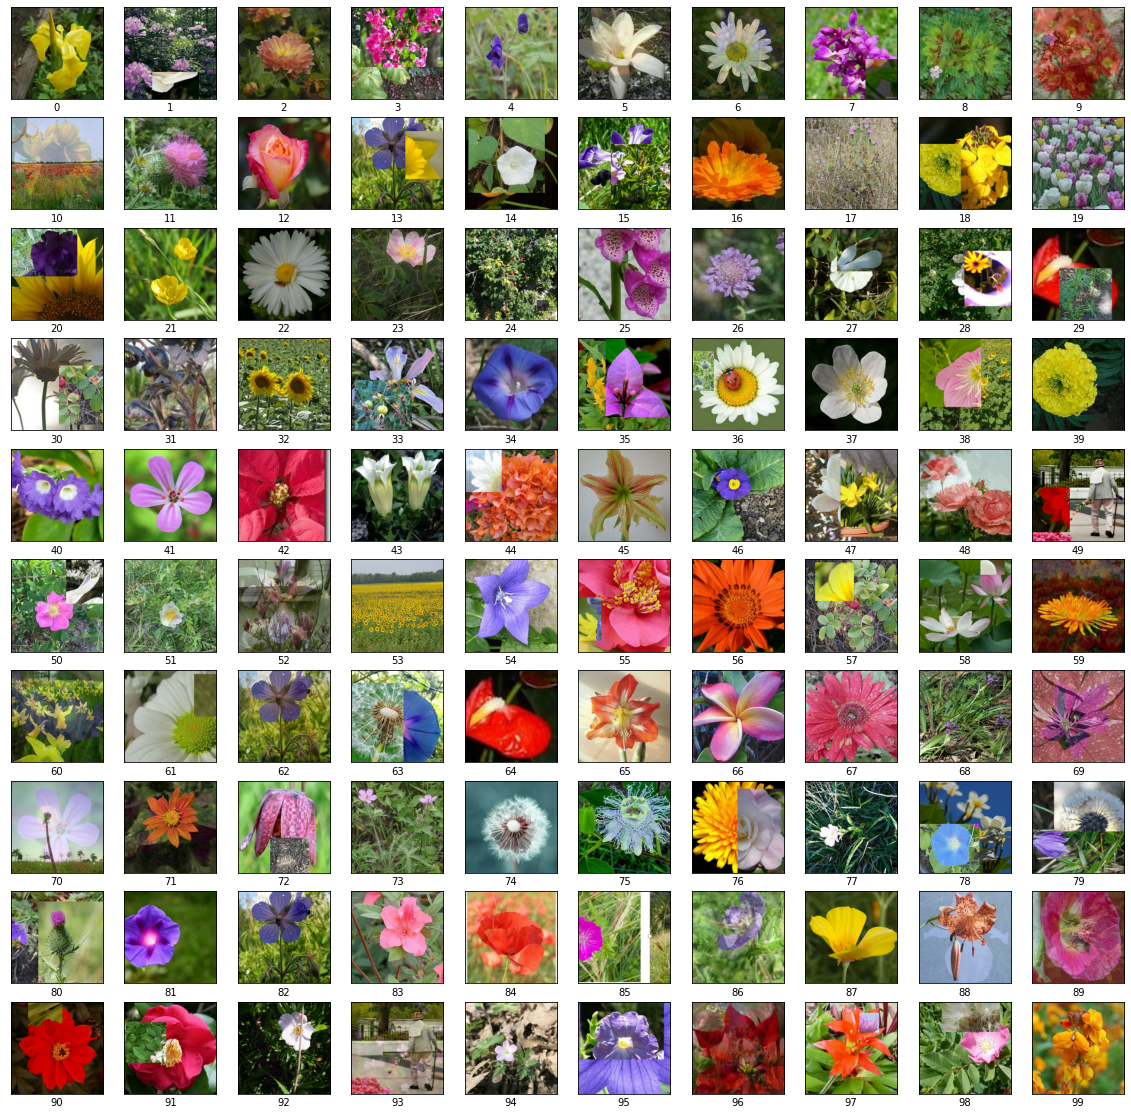

In [10]:
size = 10

images, labels = convert_batchdataset_to_numpy(next(iter(dataset_augmented.unbatch().batch(size*size))))

plt.figure(figsize=(2*size,2*size))
for i in range(size*size):
    result = (np.resize(images[i], (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)) * 255.0).astype(np.uint8)
    image = Image.fromarray(result)
    plt.subplot(size,size,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    plt.xlabel(str(i))
plt.show()

# Building the models

In [11]:
pretrained_model_name = "densenet"

if pretrained_model_name == "efficientnet":
    !pip install -q efficientnet
    import efficientnet.tfkeras as efn
    pretrained_model_generator = efn.EfficientNetB7
elif pretrained_model_name == "densenet":
    pretrained_model_generator = tf.keras.applications.densenet.DenseNet201
elif pretrained_model_name == "resnet":
    pretrained_model_generator = tf.keras.applications.ResNet152

In [12]:
pretrained_models = []

for i in range(ENSEMBLE_SIZE):
    with strategy.scope():    
        pretrained_model = pretrained_model_generator(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
        pretrained_model.trainable = False
        pretrained_models.append(pretrained_model)

74842112/74836368 [==============================] - 1s 0us/step


In [13]:
def get_model(pretrained_model):
    with strategy.scope():
        model = tf.keras.Sequential([
            # Unfortunately, the kaggle TPU tensorflow version is not high enough to use these:
            #tf.keras.layers.RandomBrightness(factor=0.2, value_range=(0.0, 1.0)),
            #tf.keras.layers.RandomContrast(factor=0.2),
            #tf.keras.layers.RandomRotation(factor=0.04),
            #tf.keras.layers.RandomFlip(),
            pretrained_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(104, activation='softmax')
        ])

        model.compile(
            optimizer="adam",
            loss = "categorical_crossentropy",
            metrics=['categorical_accuracy']
        )
    return model

models = [get_model(pretrained_model) for pretrained_model in pretrained_models]

for model in models:
    print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 16, 16, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               199784    
Total params: 18,529,448
Trainable params: 203,624
Non-trainable params: 18,325,824
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type

# Training the models

In [14]:
def lr_function(epoch, start_lr, min_lr, max_lr, rampup_epochs,
            sustain_epochs, exp_decay):
         if epoch < rampup_epochs:    
             lr = ((max_lr - start_lr) / rampup_epochs * epoch + start_lr)
         elif epoch < rampup_epochs + sustain_epochs:    
             lr = max_lr
         else:    #E
             lr = ((max_lr - min_lr) *
                       exp_decay**(epoch - rampup_epochs -
                                     sustain_epochs) + min_lr)
         return lr

def lr_1(epoch):
     start_lr = 1e-4; min_lr = 1e-5; max_lr = 0.003   
     rampup_epochs = 4; sustain_epochs = 0; exp_decay = 0.7    
  
     return lr_function(epoch, start_lr, min_lr, max_lr,
               rampup_epochs, sustain_epochs, exp_decay)

def lr_2(epoch):
     start_lr = 1e-4; min_lr = 1e-5; max_lr = 5e-4  
     rampup_epochs = 0; sustain_epochs = 0; exp_decay = 0.85
  
     return lr_function(epoch, start_lr, min_lr, max_lr,
               rampup_epochs, sustain_epochs, exp_decay)

In [15]:
for i, model in enumerate(models):
    
    print("Training model #{}".format(i+1))

    # First step of training

    history_1 = model.fit(dataset_onehot,
              steps_per_epoch=STEPS_PER_EPOCH,
              epochs=15,
              validation_data=val_dataset_onehot,
              callbacks=[
                          tf.keras.callbacks.LearningRateScheduler(lr_1, verbose=True),
                          tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=2),
              ]
            )

    # Second step: unfreeze the model

    pretrained_models[i].trainable = True

    model.compile(
        optimizer="adam",
        loss = "categorical_crossentropy",
        metrics=['categorical_accuracy']
    )

    history_2 = model.fit(dataset_onehot,
              steps_per_epoch=STEPS_PER_EPOCH,
              epochs=35,
              validation_data=val_dataset_onehot,
              callbacks=[
                          tf.keras.callbacks.LearningRateScheduler(lr_2, verbose=True),
                          tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=2),
              ]
            )
    
    
    # Because of the run-time limitations, we skip these 2 steps which I investigated while building the notebook
    
    if False:

    # Third step: using the augmented dataset

        history_3 = model.fit(dataset_augmented,
                  steps_per_epoch=STEPS_PER_EPOCH*3,
                  epochs=20,
                  validation_data=val_dataset_onehot,
                  callbacks=[
                              tf.keras.callbacks.LearningRateScheduler(lr_2, verbose=True),
                              tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=2),
                  ]
                )

        # Fourth step: use original dataset again

        history_4 = model.fit(dataset_onehot,
                  steps_per_epoch=STEPS_PER_EPOCH,
                  epochs=20,
                  validation_data=val_dataset_onehot,
                  callbacks=[
                              tf.keras.callbacks.LearningRateScheduler(lr_2, verbose=True),
                              tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=2),
                  ]
                )

Training model #1
Epoch 1/15

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
199/199 [==============================] - 150s 562ms/step - loss: 4.7053 - categorical_accuracy: 0.0465 - val_loss: 3.6219 - val_categorical_accuracy: 0.3004
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008250000000000001.
  1/199 [..............................] - ETA: 29s - loss: 3.2991 - categorical_accuracy: 0.2188

2022-10-18 09:34:12.351222: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 122421, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1666085652.347838288","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 122421, Output num: 0","grpc_status":3}


199/199 [==============================] - 68s 342ms/step - loss: 2.2231 - categorical_accuracy: 0.4846 - val_loss: 1.1129 - val_categorical_accuracy: 0.7726
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0015500000000000002.
199/199 [==============================] - 68s 340ms/step - loss: 0.9500 - categorical_accuracy: 0.7601 - val_loss: 0.6792 - val_categorical_accuracy: 0.8376
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 0.002275.
199/199 [==============================] - 68s 344ms/step - loss: 0.6468 - categorical_accuracy: 0.8275 - val_loss: 0.5957 - val_categorical_accuracy: 0.8521
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 0.003.
199/199 [==============================] - 68s 343ms/step - loss: 0.5228 - categorical_accuracy: 0.8527 - val_loss: 0.6197 - val_categorical_accuracy: 0.8564
Epoch 6/15

Epoch 00006: LearningRateScheduler reducing learning rate to 0.002103.
199/199 [=================

2022-10-18 09:52:04.973580: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 168447, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1666086724.973263050","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 168447, Output num: 1","grpc_status":3}


Epoch 2/35

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0004265.
199/199 [==============================] - 69s 344ms/step - loss: 0.6733 - categorical_accuracy: 0.8313 - val_loss: 1.2899 - val_categorical_accuracy: 0.7543
Epoch 3/35

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00036402499999999997.
199/199 [==============================] - 68s 343ms/step - loss: 0.3679 - categorical_accuracy: 0.9009 - val_loss: 0.6106 - val_categorical_accuracy: 0.8715
Epoch 4/35

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00031092125.
199/199 [==============================] - 69s 345ms/step - loss: 0.2217 - categorical_accuracy: 0.9339 - val_loss: 0.5842 - val_categorical_accuracy: 0.8871
Epoch 5/35

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0002657830625.
199/199 [==============================] - 69s 349ms/step - loss: 0.1257 - categorical_accuracy: 0.9591 - val_loss: 0.5106 - val_categorical_accuracy: 0.9044
Epoch 6/3

2022-10-18 10:16:02.144827: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 204578, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1666088162.144693505","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 204578, Output num: 1","grpc_status":3}


199/199 [==============================] - 68s 341ms/step - loss: 2.2510 - categorical_accuracy: 0.4781 - val_loss: 1.1156 - val_categorical_accuracy: 0.7718
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0015500000000000002.
199/199 [==============================] - 67s 340ms/step - loss: 0.9400 - categorical_accuracy: 0.7628 - val_loss: 0.6699 - val_categorical_accuracy: 0.8400
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 0.002275.
199/199 [==============================] - 68s 340ms/step - loss: 0.6139 - categorical_accuracy: 0.8390 - val_loss: 0.5931 - val_categorical_accuracy: 0.8553
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 0.003.
199/199 [==============================] - 67s 338ms/step - loss: 0.5223 - categorical_accuracy: 0.8549 - val_loss: 0.6097 - val_categorical_accuracy: 0.8489
Epoch 6/15

Epoch 00006: LearningRateScheduler reducing learning rate to 0.002103.
199/199 [=================

2022-10-18 10:36:01.947640: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 254082, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1666089361.947581161","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 254082, Output num: 0","grpc_status":3}


Epoch 2/35

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0004265.
199/199 [==============================] - 67s 339ms/step - loss: 0.6486 - categorical_accuracy: 0.8330 - val_loss: 1.2910 - val_categorical_accuracy: 0.7740
Epoch 3/35

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00036402499999999997.
199/199 [==============================] - 67s 338ms/step - loss: 0.3717 - categorical_accuracy: 0.8923 - val_loss: 0.9492 - val_categorical_accuracy: 0.8241
Epoch 4/35

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00031092125.
199/199 [==============================] - 67s 336ms/step - loss: 0.2543 - categorical_accuracy: 0.9295 - val_loss: 0.6657 - val_categorical_accuracy: 0.8580
Epoch 5/35

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0002657830625.
199/199 [==============================] - 67s 337ms/step - loss: 0.1405 - categorical_accuracy: 0.9576 - val_loss: 0.5247 - val_categorical_accuracy: 0.9006
Epoch 6/3

In [16]:
probabilities = np.mean([model.predict(val_dataset_images) for model in models], axis=0)
labels = next(iter(val_dataset_labels.unbatch().batch(NUM_VALIDATION_IMAGES))).numpy()
validation_accuracy = len(np.where(np.argmax(probabilities, axis=-1) == labels)[0]) / NUM_VALIDATION_IMAGES
print("Validation accuracy: {}%".format(100*validation_accuracy))

2022-10-18 10:48:56.627217: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 273582, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1666090136.626566337","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 273582, Output num: 0","grpc_status":3}


Validation accuracy: 94.61206896551724%


# Hyperparameter tuning

The following code is unused in the final version, but helped in developing the code above.

In [17]:
do_hyperparameter_tuning = False
hp_tuning_method = "bayesian" # must be "bayesian" or "hyperband"

In [18]:
if do_hyperparameter_tuning:

    # First, make sure the correct version of keras-tuner is installed

    !pip install -q keras-tuner
    !pip install --upgrade keras-tuner

    from mock import patch
    import keras_tuner as kt
    
    with strategy.scope():
        pretrained_model = pretrained_model_generator(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
        pretrained_model.trainable = False
    
    

    # In order to make keras-tuner work on Kaggle with TPUs, we have to do some finicky stuff

    def new_on_epoch_end(self, epoch, logs=None):
        if not self.objective.has_value(logs):
            # Save on every epoch if metric value is not in the logs. Either no
            # objective is specified, or objective is computed and returned
            # after `fit()`.

            #***** the following are the lines I added ******************************************
            # Save model in Tensorflow's "SavedModel" format

            save_locally = tf.saved_model.SaveOptions(experimental_io_device = '/job:localhost')

            # I then added ', options = save_locally' to the line below.
            #************************************************************************************

            self.model.save_weights(self.filepath, options = save_locally)
            return
        current_value = self.objective.get_value(logs)
        if self.objective.better_than(current_value, self.best_value):
            self.best_value = current_value

            #***** the following are the lines I added ******************************************
            # Save model in Tensorflow's "SavedModel" format

            save_locally = tf.saved_model.SaveOptions(experimental_io_device = '/job:localhost')

            # I then added ', options = save_locally' to the line below.
            #************************************************************************************

            self.model.save_weights(self.filepath, options = save_locally)

I couldn't find any reference online on how to use keras_tuner with TPUs and a custom training loop (I wanted to control hyperparameters related to batch size, for example) so I am including the following code in case it will be useful to someone. I ended up not using it and just trying out a few batch sizes by hand and automatically tuning the other hyperparameters, as my custom training loop was slower than the default one and I couldn't figure out why.

In [19]:
if do_hyperparameter_tuning and False:

    # Define the model generator and tuner
    
    class MyHyperModel(kt.HyperModel):
        def build(self, hp):
            model = tf.keras.Sequential([
                pretrained_model,
                tf.keras.layers.GlobalAveragePooling2D()
            ]
            + ([tf.keras.layers.BatchNormalization()] if hp.Boolean("batch_normalization") else [])
            + ([tf.keras.layers.Dropout(0.2)] if hp.Boolean("dropout") else [])
            + [
                tf.keras.layers.Dense(104, activation='softmax')
            ])
            
            self.batch_size = hp.Choice("batch_size", [8, 16, 32, 64]) * strategy.num_replicas_in_sync
                
            # Define the optimizer and loss function
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Float("lr", 1e-4, 2.5e-2, sampling="log"))
            #self.loss_fn = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
            self.loss_fn = lambda a,b: tf.nn.compute_average_loss(tf.keras.losses.categorical_crossentropy(a,b), global_batch_size=self.batch_size)
            # Define various metrics
            self.train_accuracy = tf.keras.metrics.CategoricalAccuracy()
            self.valid_accuracy = tf.keras.metrics.CategoricalAccuracy()
            self.train_loss = tf.keras.metrics.Sum()
            self.valid_loss = tf.keras.metrics.Sum()
            
            return model

        def fit(self, hp, model, x, y, validation_data, callbacks=None, **kwargs):
            
            batch_size = self.batch_size
            train_ds = x.unbatch().batch(batch_size)
            validation_data = validation_data.unbatch().batch(batch_size)
            
            optimizer = self.optimizer
            loss_fn = self.loss_fn
            train_accuracy = self.train_accuracy
            valid_accuracy = self.valid_accuracy
            train_loss = self.train_loss
            valid_loss = self.valid_loss

            # Function to run the train step.
            @tf.function
            def run_train_step(images, labels):
                with tf.GradientTape() as tape:
                    probabilities = model(images)
                    #loss = tf.reduce_sum(loss_fn(labels, probabilities)) * (1.0 / batch_size)
                    loss = loss_fn(labels, probabilities)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                # Update metrics
                train_accuracy.update_state(labels, probabilities)
                train_loss.update_state(loss)

            # Function to run the validation step.
            @tf.function
            def run_val_step(images, labels):
                probabilities = model(images)
                loss = loss_fn(labels, probabilities)
                # Update metrics
                valid_accuracy.update_state(labels, probabilities)
                valid_loss.update_state(loss)

            # Assign the model to the callbacks.
            for callback in callbacks:
                callback.model = model

            # Record the best validation loss value
            best_epoch_accuracy = float("inf")

            # The custom training loop.
            for epoch in range(100):
                print(f"Epoch: {epoch}")

                # Iterate the training data to run the training step.
                for step, (images, labels) in enumerate(train_ds):
                    strategy.run(run_train_step, args=(images, labels))
                    print('=', end='', flush=True)
                    if step > STEPS_PER_EPOCH:
                        break
                    
                print('|', end='', flush=True)

                # Iterate the validation data to run the validation step.
                for images, labels in validation_data:
                    strategy.run(run_val_step, args=(images, labels))
                    print('=', end='', flush=True)
                    
                print("")

                # Calling the callbacks after epoch.
                epoch_train_accuracy = float(train_accuracy.result().numpy())
                epoch_val_accuracy = float(valid_accuracy.result().numpy())
                for callback in callbacks:
                    callback.on_epoch_end(epoch, logs={"categorical_accuracy": epoch_train_accuracy, "val_categorical_accuracy": epoch_val_accuracy})
                train_accuracy.reset_states()
                valid_accuracy.reset_states()
                train_loss.reset_states()
                valid_loss.reset_states()

                print("Accuracy: {}\nValdation accuracy: {}".format(epoch_train_accuracy, epoch_val_accuracy))
                best_epoch_accuracy = min(best_epoch_accuracy, epoch_val_accuracy)

            # Return the evaluation metric value.
            return best_epoch_accuracy

    tuner = kt.BayesianOptimization(
        hypermodel=MyHyperModel(),
        objective='val_categorical_accuracy',
        max_trials=20,
        distribution_strategy=strategy,
        directory=".",
        project_name="tuner"
    )


    # Finally, do the hyperparameter search and print the results

    with patch('keras_tuner.engine.tuner_utils.SaveBestEpoch.on_epoch_end', new_on_epoch_end):
        tuner.search(dataset_onehot, None,
             validation_data=val_dataset_onehot,
             steps_per_epoch=STEPS_PER_EPOCH,
             epochs=10,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

    hp = tuner.get_best_hyperparameters()

In [20]:
if do_hyperparameter_tuning:
    
    @tf.function
    def lr_function(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        rampup = lambda: ((max_lr - start_lr) / (rampup_epochs + 1e-10) * float(epoch) + start_lr)
        sustain = lambda: max_lr
        decay = lambda: ((max_lr - min_lr) * exp_decay**(float(epoch) - rampup_epochs - sustain_epochs) + min_lr)
        lr = tf.cond(tf.less(epoch, tf.convert_to_tensor(rampup_epochs)), rampup, lambda: tf.cond(tf.less(epoch, tf.convert_to_tensor(rampup_epochs + sustain_epochs)), sustain, decay))
        return lr

    # Define the model generator and tuner
    
    def build_model(hp):
        model = tf.keras.Sequential([
            pretrained_model,
            tf.keras.layers.GlobalAveragePooling2D()
        ]
        + ([tf.keras.layers.BatchNormalization()] if hp.Boolean("batch_normalization", default=True) else [])
        + ([tf.keras.layers.Dropout(0.2)] if hp.Boolean("dropout", default=True) else [])
        + [
            tf.keras.layers.Dense(104, activation='softmax')
        ])

        start_lr = 1e-5; min_lr = 1e-5; max_lr = float(hp.Float("max_lr", 1e-4, 1e-1, sampling="log", default=1e-2))    
        rampup_epochs = float(hp.Int("rampup_epochs", 0, 5, default=2)); sustain_epochs = float(hp.Int("sustain_epochs", 0, 2, default=0)); exp_decay = float(hp.Float("lr_decay", 0.5, 0.99, default=0.8))   

        class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
            def __call__(self, step):
                epoch = step // STEPS_PER_EPOCH
                return lr_function(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)

        # Define the optimizer and loss function
        optimizer = tf.keras.optimizers.Adam(learning_rate=LRSchedule())

        model.compile(
            optimizer=optimizer,
            loss = "categorical_crossentropy",
            metrics=['categorical_accuracy']
        )

        return model
    
    if hp_tuning_method == "bayesian":
        tuner = kt.BayesianOptimization(
            build_model,
            objective='val_categorical_accuracy',
            max_trials=20,
            distribution_strategy=strategy,
            directory=".",
            project_name="tuner"
        )
    else:
        tuner = kt.HyperbandOptimization(
            build_model,
            objective='val_categorical_accuracy',
            hyperband_iterations=2,
            distribution_strategy=strategy,
            directory=".",
            project_name="tuner"
        )


    # Finally, do the hyperparameter search and print the results

    with patch('keras_tuner.engine.tuner_utils.SaveBestEpoch.on_epoch_end', new_on_epoch_end):
        tuner.search(dataset_onehot,
             validation_data=val_dataset_onehot,
             steps_per_epoch=STEPS_PER_EPOCH,
             epochs=10,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

    hp = tuner.get_best_hyperparameters()
    
    parameters = ["batch_normalization", "dropout", "max_lr", "rampup_epochs", "sustain_epochs", "lr_decay"]
    
    for p in hp:
        for param in parameters:
            print("{}: {}".format(param, p.get(param)))

In [21]:
if do_hyperparameter_tuning:
    model = build_model(hp[0])
    model.fit(dataset_onehot,
          steps_per_epoch=STEPS_PER_EPOCH,
          epochs=100,
          validation_data=val_dataset_onehot,
          callbacks=[
                      tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=2),
          ]
        )

In [22]:
if do_hyperparameter_tuning:
    
    for layer in model.layers:
        layer.trainable = True
    first_phase_model = model

    # Define the model generator and tuner
    
    def build_model_2(hp):
        model = tf.keras.models.clone_model(first_phase_model)

        start_lr = 1e-5; min_lr = 1e-5; max_lr = float(hp.Float("max_lr", 1e-4, 2.5e-2, sampling="log"))    
        rampup_epochs = float(hp.Int("rampup_epochs", 0, 5, default=1)); sustain_epochs = float(hp.Int("sustain_epochs", 0, 2)); exp_decay = float(hp.Float("lr_decay", 0.5, 0.99))   

        class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
            def __call__(self, step):
                epoch = step // STEPS_PER_EPOCH
                return lr_function(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)

        # Define the optimizer and loss function
        optimizer = tf.keras.optimizers.Adam(learning_rate=LRSchedule())
        
        model.compile(
            optimizer=optimizer,
            loss = "categorical_crossentropy",
            metrics=['categorical_accuracy']
        )

        return model

    tuner_2 = kt.BayesianOptimization(
        build_model_2,
        objective='val_categorical_accuracy',
        max_trials=20,
        distribution_strategy=strategy,
        directory=".",
        project_name="tuner"
    )


    # Finally, do the hyperparameter search and print the results

    with patch('keras_tuner.engine.tuner_utils.SaveBestEpoch.on_epoch_end', new_on_epoch_end):
        tuner_2.search(dataset_onehot,
             validation_data=val_dataset_onehot,
             steps_per_epoch=STEPS_PER_EPOCH,
             epochs=10,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

    hp = tuner_2.get_best_hyperparameters()
    
    parameters = ["batch_normalization", "dropout", "max_lr", "rampup_epochs", "sustain_epochs", "lr_decay"]
    
    for p in hp:
        for param in parameters:
            print("{}: {}".format(param, p.get(param)))

# Making the final predictions and generating submission file

In [23]:
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = np.mean([model.predict(test_images_ds) for model in models], axis=0)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

2022-10-18 10:50:42.393413: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Computing predictions...


2022-10-18 10:51:42.005418: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 274364, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1666090302.005212286","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 274364, Output num: 0","grpc_status":3}


[67 45 81 ... 14 40 79]


In [24]:
NUM_TEST_IMAGES = predictions.shape[0]

In [25]:
print('Generating submission.csv file...')

# Get image ids from test set and convert to unicode
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

# Look at the first few predictions
!head submission.csv

Generating submission.csv file...
id,label
252d840db,67
dfd946ac8,45
0c3ae4377,81
a31f90373,67
0bf251179,73
2dd56f346,69
d5320553f,68
e45a81eb4,4
6074e6638,43
